# Diplomatura en Ciencias de Datos, Aprendizaje Automático y sus Aplicaciones

Autores: Matías Oria, Antonela Sambuceti, Pamela Pairo, Benjamín Ocampo

## Definición de funciones *helper*
Inicialmente se definen funciones que se utilizaron durante la selección e
imputación de columnas del conjunto de datos obtenido en
`melbourne_exploration.py` y almacenados en un servidor para su acceso remoto.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.experimental import enable_iterative_imputer
from sklearn import (base, decomposition, feature_extraction, impute,
                     neighbors, preprocessing)
from typing import List, Tuple, Union


def plot_imputation_graph(imputations: List[Tuple[str, pd.DataFrame]],
                          missing_cols: List[str]) -> None:
    """
    Makes a group of density plots according to the number of columns on the
    dataframes inside @imputations. @imputations must be a list of pairs
    (@method_name, @value_df) where each @value_df has the same @missing_cols
    obtained by its corresponding imputer @method_name.
    """
    _, axs = plt.subplots(len(missing_cols), figsize=(10, 10))
    for ax, col_name in zip(axs, missing_cols):
        data = pd.concat([
            imputation_df[[col_name]].assign(method=method)
            for method, imputation_df in imputations
        ])
        seaborn.kdeplot(data=data, x=col_name, hue="method", ax=ax)


def impute_by(values: Union[np.array, pd.DataFrame],
              missing_col_names: List[str],
              estimator: base.BaseEstimator) -> pd.DataFrame:
    """
    Returns a dataframe that fills null entries of @values according to
    @estimator. @missing_col_names are labels that will be assigned when
    created. @values might have columns that doesn't have null values, such that
    the IterativeImputer class takes advantage of it in order to estimate
    missing values.
    """
    indicator = impute.MissingIndicator()
    indicator.fit_transform(values)

    imputer = impute.IterativeImputer(
        random_state=0, estimator=estimator)
    imputed_values = imputer.fit_transform(values)
    imputed_df = pd.DataFrame(imputed_values[:, indicator.features_],
                              columns=missing_col_names)
    return imputed_df

In [2]:
URL_MELB_HOUSING_FILTERED = "https://www.famaf.unc.edu.ar/~nocampo043/melb_housing_filtered_df.csv"
URL_MELB_SUBURB_FILTERED = "https://www.famaf.unc.edu.ar/~nocampo043/melb_suburb_filtered_df.csv"

melb_housing_df = pd.read_csv(URL_MELB_HOUSING_FILTERED)
melb_suburb_df = pd.read_csv(URL_MELB_SUBURB_FILTERED)
melb_combined_df = melb_housing_df.join(melb_suburb_df, on="suburb_id")
melb_combined_df

,housing_price,housing_room_segment,housing_bathroom_segment,housing_land_size,housing_building_area,housing_type,housing_year_built,suburb_id,suburb_name,suburb_region_segment,suburb_council_area,suburb_rental_dailyprice
0,1480000.0,"(1, 2]","(0, 1]",202.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
1,1035000.0,"(1, 2]","(0, 1]",156.0,79.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
2,1465000.0,"(2, 3]","(1, 2]",134.0,150.0,h,1900.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
3,850000.0,"(2, 3]","(1, 2]",94.0,NaN,h,NaN,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
4,1600000.0,"(3, 4]","(0, 1]",120.0,142.0,h,2014.0,0,Abbotsford,Northern Metropolitan,['Yarra'],117.719512
...,...,...,...,...,...,...,...,...,...,...,...,...
13201,1245000.0,"(3, 4]","(1, 2]",652.0,NaN,h,1981.0,248,Wheelers Hill,South-Eastern Metropolitan,['Monash'],109.742268
13202,1031000.0,"(2, 3]","(1, 2]",333.0,133.0,h,1995.0,104,Williamstown,Western Metropolitan,['Hobsons Bay'],177.911765
13203,1170000.0,"(2, 3]","(1, 2]",436.0,NaN,h,1997.0,104,Williamstown,Western Metropolitan,['Hobsons Bay'],177.911765
13204,2500000.0,"(3, 4]","(0, 1]",866.0,157.0,h,1920.0,104,Williamstown,Western Metropolitan,['Hobsons Bay'],177.911765


## Encoding
Con el fin de poder entrenar un modelo bajo las variables en `melb_combined_df`,
se deben codificar aquellas que sean categóricas. Para ello, se utiliza *One-Hot
Encoding* donde se muestran dos posibles métodos distintos.

### Dict Vectorizer

In [3]:
categorical_cols = [
    "housing_room_segment", "housing_bathroom_segment", "housing_type",
    "suburb_region_segment"
]
numerical_cols = [
    "housing_price", "housing_land_size", "suburb_rental_dailyprice"
]
feature_cols = categorical_cols + numerical_cols
features = list(melb_combined_df[feature_cols].T.to_dict().values())

vectorizer = feature_extraction.DictVectorizer()
feature_matrix = vectorizer.fit_transform(features)
feature_matrix

<13206x20 sparse matrix of type '<class 'numpy.float64'>'
	with 92442 stored elements in Compressed Sparse Row format>

In [4]:
vectorizer.get_feature_names()

['housing_bathroom_segment=(0, 1]',
 'housing_bathroom_segment=(1, 2]',
 'housing_bathroom_segment=(2, 8]',
 'housing_land_size',
 'housing_price',
 'housing_room_segment=(0, 1]',
 'housing_room_segment=(1, 2]',
 'housing_room_segment=(2, 3]',
 'housing_room_segment=(3, 4]',
 'housing_room_segment=(4, 10]',
 'housing_type=h',
 'housing_type=t',
 'housing_type=u',
 'suburb_region_segment=Eastern Metropolitan',
 'suburb_region_segment=Northern Metropolitan',
 'suburb_region_segment=South-Eastern Metropolitan',
 'suburb_region_segment=Southern Metropolitan',
 'suburb_region_segment=Victoria',
 'suburb_region_segment=Western Metropolitan',
 'suburb_rental_dailyprice']

Se obtiene una matriz de $13206 \times 20$ cuyas columnas son las que se
muestran por `get_feature_names()`.

Del total de variables de `melb_combined_df`, se excluyen `suburb_name` y
`suburb_council_area` con el fin de obtener una matriz cuyo espacio en memoria
no imposibilite la imputación de las variables numéricas `housing_year_built` y
`housing_building_area` en una sección posterior. A su vez, se presentó otra
forma de realizar una codificación *one-hot* con fin complementario. No
obstante, se trabajó sobre la matriz dada por el método `Dict Vectorizer`.

### One-Hot Encoding
Otro forma posible de obtener la matriz de *features* es por medio de la clase
`OneHotEncoder` realizando la codificación sobre `categorical_cols`.

In [5]:
ohe = preprocessing.OneHotEncoder(sparse=False)
feature_matrix_ohe = np.hstack([
    ohe.fit_transform(melb_combined_df[categorical_cols]),
    melb_combined_df[numerical_cols]
])
feature_matrix_ohe.shape

(13206, 20)

De manera similar, se obtiene la matriz codificada donde las primeras 17
columnas corresponden a la codificación de las variables categóricas, y las 3
restantes a las numéricas que no requerían este paso.

## Imputación por KNN
En esta sección se procedió a imputar las variables `housin_year_built` y
`housing_building_area` con el fin de incluirlas en la matriz de *features*.
Para ello, se realizaron imputaciones univariadas y multivariadas, es decir,
utilizando solamente valores no nulos de dichas variables para realizar la
imputación, en comparación a, aprovechar todos los *features* disponibles en la
matriz obtenida en la sección anterior. A su vez, esta comparación también se
realizó estandarizando las variables con el fin de verificar si influía en la
imputación resultante.

### Sin estandarizado

In [6]:
missing_cols = ["housing_year_built", "housing_building_area"]
estimator = neighbors.KNeighborsRegressor(n_neighbors=2)

In [7]:
missing_df = melb_combined_df[missing_cols]
original_df = missing_df.dropna()
all_df = np.hstack([missing_df, feature_matrix.todense()])

knn_missing_cols = impute_by(missing_df, missing_cols, estimator)
knn_all_cols = impute_by(all_df, missing_cols, estimator)

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


Para la comparación se crean 3 *dataframes*:
  - `original_df`: Contiene las columnas de `housing_year_built` y
    `housing_building_area` eliminando aquellos valores faltantes.
  - `missing_df`: Similar a `original_df` pero sin eliminar las entradas nulas.
  - `all_df`: Contiene todas las *features* obtenidas en la sección de
    codificación junto a las de `missing_df`.

Posteriormente, se procedió a imputar los valores faltantes que ocurren en las
entradas de `missing_df` y `all_df` por medio de `impute_by`, una de las
funciones *helper* definidas en la primera sección, generando un nuevo
*dataframe* con aquellos datos completados por el estimador `KNeighbors`.

Por último, las distribuciones de las observaciones de los *dataframes*
resultantes se comparan por medio de un gráfico de densidad.

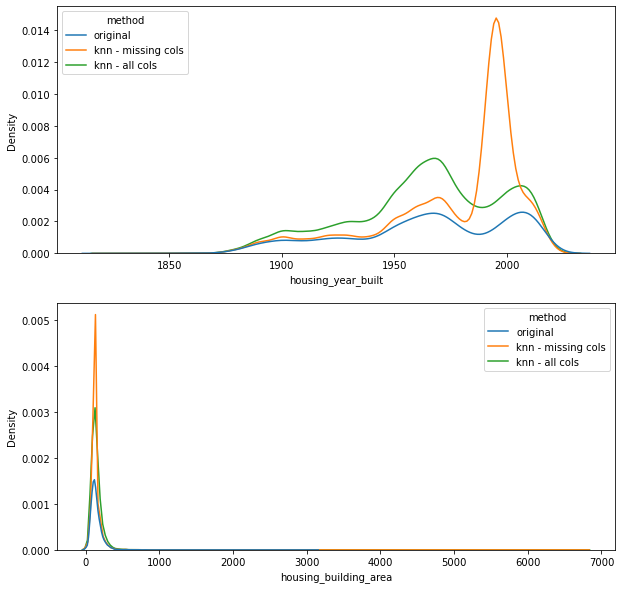

In [8]:
imputations = [
    ("original", original_df),
    ("knn - missing cols", knn_missing_cols),
    ("knn - all cols", knn_all_cols)
]
plot_imputation_graph(imputations, missing_cols)

Se puede observar que la distribución de `housing_year_built` luego de imputar
por medio de todas las columnas captura en mejor medida la tendencia
correspondiente a su original. Especialmente para aquellas viviendas con poca
antigüedad al momento de la venta. Similarmente, puede darse la misma
aseveración para la variable `housing_bulding_area`.

### Con estandarizado

In [9]:
scaler = preprocessing.StandardScaler()
original_scaled_df = pd.DataFrame(scaler.fit_transform(original_df),
                                  columns=missing_cols)
knn_scaled_missing_cols = impute_by(scaler.fit_transform(missing_df),
                                    missing_cols, estimator)
knn_scaled_all_cols = impute_by(scaler.fit_transform(all_df), missing_cols,
                                estimator)

C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"
C:\Users\Pame\anaconda3\envs\diplo\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


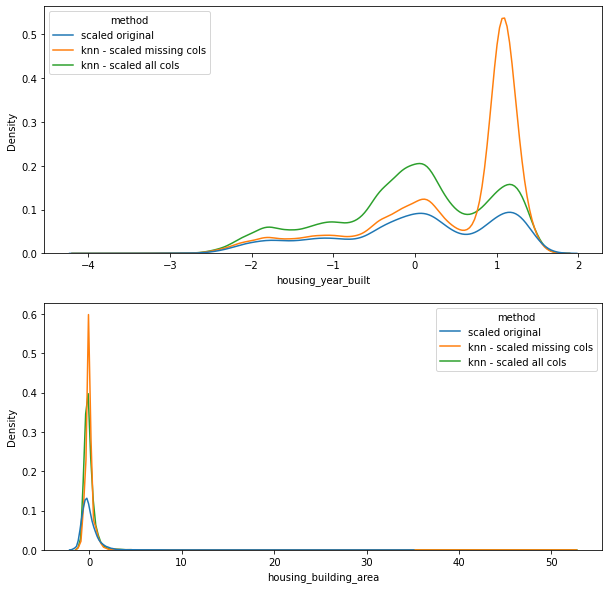

In [10]:
imputations = [
    ("scaled original", original_scaled_df),
    ("knn - scaled missing cols", knn_scaled_missing_cols),
    ("knn - scaled all cols", knn_scaled_all_cols)
]
plot_imputation_graph(imputations, missing_cols)

Escalando los datos de manera previa a la imputación no pareció afectar la
elección de un método por sobre otro. Se puede observar que la manera en que se
distribuyen ambas variables es similar al caso anterior salvo por el cambio de
escala en los ejes x e y. Por lo tanto, se optó por incluir la imputación con
todas las *features* sin estandarizado previo a la matriz resultante de la
sección anterior.

In [11]:
feature_matrix = np.hstack([feature_matrix.todense(), knn_all_cols])
feature_matrix.shape

## Reducción de dimensionalidad

### Análisis de Componentes Principales (`PCA`)
Antes de realizar el `PCA` se realiza la estandarización de los datos, es decir
a cada dato se le resta su media y se lo divide por el desvío estándar. La
estandarización permite trabajar con variables medidas en distintas unidades y
así dar el mismo peso a todas las variables.

In [22]:
feature_matrix_standarized = preprocessing.StandardScaler().fit_transform(
    feature_matrix)

A continuación se muestra a modo de ejemplo el cambio de los valores antes y
después de la estandarización para la fila 6.

In [43]:
print('\nAntes de estandarizar \n%s' %feature_matrix[5])
print('\nDespués de estandarizar \n%s' %feature_matrix_standarized[5])


Antes de estandarizar 
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 1.81000000e+02
  9.41000000e+05 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.17719512e+02
  1.99050000e+03 1.25500000e+02]]

Después de estandarizar 
[ 0.87049022 -0.75887745 -0.26507549 -0.23396802 -0.1398687  -0.23317645
  1.62173256 -0.88699926 -0.48382876 -0.21180449  0.6739771  -0.30277982
 -0.54403717 -0.35215132  1.55603455 -0.18739056 -0.70409703 -0.097754
 -0.53502985 -0.14599648  0.79985318 -0.14816312]


In [25]:
_, nof_components = feature_matrix_standarized.shape
pca = decomposition.PCA(n_components=nof_components)
principal_components = pca.fit_transform(feature_matrix_standarized)

Se muestra la varianza explicada por cada componente

In [34]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([1.70897728e-01, 1.02284858e-01, 8.69834362e-02, 7.47646780e-02,
       6.21809000e-02, 5.94767880e-02, 5.54138576e-02, 5.13408331e-02,
       4.98153270e-02, 4.75253769e-02, 4.39038188e-02, 4.10687149e-02,
       3.70542292e-02, 3.13082442e-02, 3.09145966e-02, 2.49832420e-02,
       1.71317504e-02, 1.29516208e-02, 2.45262023e-29, 7.09866583e-31,
       1.72868239e-32, 4.71945782e-33])

Para una mejor comprensión se calcula el porcentaje acumulado explicado por cada
componente. El primer componente explica el 17,09% de la variación. Luego, el
primer y segundo componente explican el 27.32% de la variación y así
sucesivamente.

In [28]:
acc_variance_percent = np.cumsum(np.round(explained_variance, decimals=4) * 100)
acc_variance_percent

array([ 17.09,  27.32,  36.02,  43.5 ,  49.72,  55.67,  61.21,  66.34,
        71.32,  76.07,  80.46,  84.57,  88.28,  91.41,  94.5 ,  97.  ,
        98.71, 100.01, 100.01, 100.01, 100.01, 100.01])

Se eligen las primeras 18 componentes que explican el 98,71% de la variación y
también a partir de ese valor se llega al *plateau* (meseta).

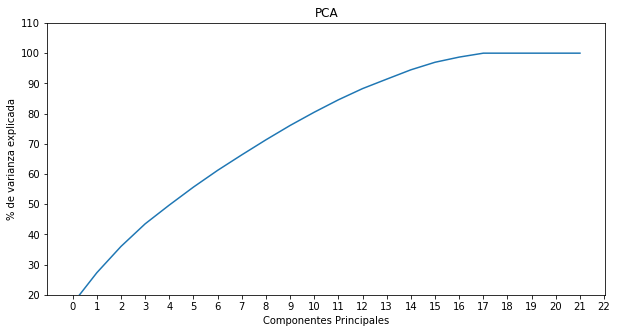

In [58]:
plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(range(nof_components))
plt.plot(acc_variance_percent)

El siguiente gráfico muestra en conjunto la varianza explicada por cada
componente (barra) y la varianza acumulada (línea escalonada).

In [36]:
acc_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_variance)),
        explained_variance,
        alpha=0.5,
        align='center',
        label='Varianza explicada individual')
plt.step(range(len(acc_variance)),
         acc_variance,
         where='mid',
         label='Varianza explicada acumulada')
plt.ylabel('Radio de varianza explicada')
plt.xlabel('Componentes principales')
plt.legend(loc='best')
plt.xticks(range(nof_components))
plt.tight_layout()
plt.show()

## Composición del resultado
Para finalizar, se crea un nuevo *dataframe* que contenga las codificaciones de
las variables categóricas y numéricas, las imputaciones de columnas que
presentaban valores faltantes, y las primeras 18 componentes principales
observadas en la sección anterior. El conjunto resultante es puesto a
disposición para su acceso remoto a través de la siguiente URL:
- [Codificación del conjunto de
  datos](https://www.famaf.unc.edu.ar/~nocampo043/encoded_melb_df.csv)

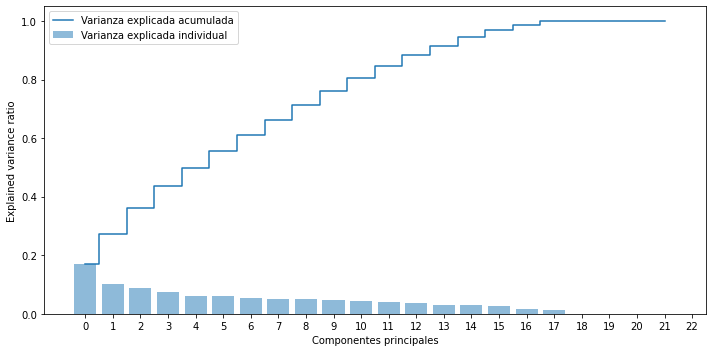

In [56]:
nof_selected_components = 18
new_columns = vectorizer.get_feature_names()

new_columns = (
    vectorizer.get_feature_names() + missing_cols +
    [f"pca_{component_id}" for component_id in range(nof_selected_components)])

encoded_melb_df = pd.DataFrame(
    data=np.hstack([
        feature_matrix,
        principal_components[:, :nof_selected_components]]),
    columns=new_columns)
encoded_melb_df

In [ ]:
encoded_melb_df.to_csv("encoded_melb_df.csv", index=False)